In [19]:
import pandas as pd
import numpy as np
import scipy
import sklearn

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [21]:
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel, SelectPercentile, chi2, VarianceThreshold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, RandomForestRegressor
from sklearn import metrics

In [22]:
import optuna
from optuna.visualization import plot_intermediate_values

In [23]:
from optuna.samplers import TPESampler

In [24]:
import numpy as np
import xgboost as xgb
import lightgbm as lgb

In [25]:
SEED = 85

In [26]:
from hypster_xgboost import *
from hypster import *

# Get Dataset

In [27]:
from scipy.sparse import csr_matrix, save_npz, load_npz

In [89]:
dataset = "boston" #adult, boston

In [90]:
if dataset=="adult":
    X_train = pd.read_pickle("./data/adult_X_train.pkl")
    y_train = pd.read_pickle("./data/adult_y_train.pkl")
    X_test = pd.read_pickle("./data/adult_X_test.pkl")
    y_test = pd.read_pickle("./data/adult_y_test.pkl")
    cat_cols = X_train.select_dtypes(include="object").columns
elif dataset=="newsgroup":
    X_train = load_npz("./data/X_train.npz")
    y_train = pd.read_pickle("./data/y_train.pkl")
    X_test = load_npz("./data/X_test.npz")
    y_test = pd.read_pickle("./data/y_test.pkl")
    cat_cols=None
else:
    X_train = pd.read_pickle("./data/boston_X_train.pkl")
    y_train = pd.read_pickle("./data/boston_y_train.pkl")
    X_test = pd.read_pickle("./data/boston_X_test.pkl")
    y_test = pd.read_pickle("./data/boston_y_test.pkl")
    cat_cols = None

In [91]:
X = X_train

In [104]:
X_train["cat"] = pd.Series(["hi"] * (X_train.shape[0]))

In [105]:
X_test["cat"] = pd.Series(["hi"] * (X_train.shape[0]))

In [107]:
t = TargetEncoder(cols = "cat")

In [111]:
X_train.shape

(339, 14)

In [110]:
y.shape

(32561,)

In [113]:
t.fit_transform(X_train, y_train)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,cat
107,0.13117,0.0,8.56,0.0,0.5200,6.127,85.2,2.1224,5.0,384.0,20.9,387.69,14.09,25.185022
368,4.89822,0.0,18.10,0.0,0.6310,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26,17.381250
224,0.31533,0.0,6.20,0.0,0.5040,8.266,78.3,2.8944,8.0,307.0,17.4,385.05,4.14,25.185022
274,0.05644,40.0,6.41,1.0,0.4470,6.758,32.9,4.0776,4.0,254.0,17.6,396.90,3.53,25.185022
202,0.02177,82.5,2.03,0.0,0.4150,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11,25.185022
371,9.23230,0.0,18.10,0.0,0.6310,6.216,100.0,1.1691,24.0,666.0,20.2,366.15,9.53,17.381250
443,9.96654,0.0,18.10,0.0,0.7400,6.485,100.0,1.9784,24.0,666.0,20.2,386.73,18.85,17.381250
381,15.87440,0.0,18.10,0.0,0.6710,6.545,99.1,1.5192,24.0,666.0,20.2,396.90,21.08,17.381250
273,0.22188,20.0,6.96,1.0,0.4640,7.691,51.8,4.3665,3.0,223.0,18.6,390.77,6.58,25.185022
308,0.49298,0.0,9.90,0.0,0.5440,6.635,82.5,3.3175,4.0,304.0,18.4,396.90,4.54,25.185022


In [ ]:
t

In [92]:
y = np.array(y)

In [93]:
#y = LabelEncoder().fit_transform(y_train)

In [94]:
#X = X_train

In [95]:
numeric_cols = None
if cat_cols is None:
    if isinstance(X, pd.DataFrame):
        numeric_cols = X.columns
    else:
        numeric_cols = list(range(X.shape[1]))
else:
    if len(cat_cols) < X.shape[1]:
        if (isinstance(X, pd.DataFrame)) and (isinstance(cat_cols[0], str)):
            numeric_cols = list(set(X.columns).difference(cat_cols))
        else:
            numeric_cols = np.array(list(set(range(X.shape[1])).difference(cat_cols)))

In [96]:
numeric_cols

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')

In [97]:
cat_cols

In [33]:
from sklearn.pipeline import Pipeline

In [34]:
def contains_nan(X):
    if isinstance(X, pd.DataFrame):
        return pd.isnull(X).values.any()
    elif sp.issparse(X):
        return pd.isnull(X.data).any()
    else: return pd.isnull(X).any() #numpy

In [35]:
from sklearn.base import clone

In [36]:
from sklearn.compose import ColumnTransformer

In [37]:
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
def add_to_pipe(pipe, name, step, cols=None, cols_name=None, 
                remainder="passthrough", n_jobs=1):
    if cols is not None:
        step = ColumnTransformer(transformers=[(name, step, cols)], 
                                 remainder=remainder, 
                                 sparse_threshold=0,
                                 n_jobs=n_jobs)
        
        name = cols_name if cols_name is not None else name
    if pipe is None:
        pipe_res = Pipeline([(name, step)])
    else:
        pipe_res = clone(pipe)
        step_names = [step[0] for step in pipe_res.steps]
        if name not in step_names:
            pipe_res.steps.append([name, step])
    return pipe_res

In [38]:
cat_enc_type = "target"

In [39]:
supports_categorical = False

In [40]:
handles_categorical_nan = False

In [41]:
from sklearn.pipeline import FeatureUnion

In [42]:
cat_transforms = None
cat_pipe = None
if (cat_cols is not None):
    if supports_categorical == False:
        from category_encoders import BinaryEncoder, OneHotEncoder, CatBoostEncoder, HashingEncoder, TargetEncoder
        cat_enc_types = ["binary", "target", "catboost"] #, "hash_encoder"
        large_threshold = 6
        large_cardinal_cats = [col for col in X[cat_cols].columns if X[col].nunique() > large_threshold]
        small_cardinal_cats = [col for col in X[cat_cols].columns if X[col].nunique() <= large_threshold]
        if small_cardinal_cats is not None:
            cat_transforms = add_to_pipe(cat_transforms, "ohe", OneHotEncoder(cols=small_cardinal_cats, drop_invariant=True))
        if large_cardinal_cats is not None:
            if cat_enc_type == "binary":
                #mapping = get_mapping(X, large_cardinal_cats)
                enc = BinaryEncoder(cols=large_cardinal_cats, 
                                    drop_invariant=True,
                                    #mapping=mapping
                                   )
            elif cat_enc_type == "hash": #slow!
                n_components = 50 #TODO: sample
                enc = HashingEncoder(n_components=n_components,
                                     cols=large_cardinal_cats, 
                                     drop_invariant=True)
            elif cat_enc_type == "target":
                min_samples_leaf = 10 #TODO: calculate percentage or something else
                enc = TargetEncoder(min_samples_leaf=min_samples_leaf,
                                   cols=large_cardinal_cats,
                                   drop_invariant=True)
            else: #catboost
                enc = CatBoostEncoder(cols=large_cardinal_cats,
                                      drop_invariant=True,
                                      random_state=SEED) #TODO: replace SEED
                #TODO: permute to the dataset beforehand
            cat_transforms = add_to_pipe(cat_transforms, cat_enc_type + "_encoder", enc)
            cat_transform_name = "cat_encoder"
    elif (contains_nan(X[cat_cols])) and (handles_categorical_nan == False):
        cat_transforms = ("imputer", SimpleImputer(strategy="constant", fill_value="unknown"))
        cat_transform_name = "imputer"

if cat_transforms is not None:
    if numeric_cols is None:
        cat_pipe = add_to_pipe(cat_pipe, cat_transform_name, cat_transforms)
    else:
        cat_pipe = add_to_pipe(cat_pipe, cat_transform_name, cat_transforms, cols=cat_cols, 
                               cols_name="cat_transforms", remainder="drop")

In [43]:
handles_numeric_nan = False
sparse = False
sensitive_to_scaling = False

In [44]:
X.shape

(32561, 14)

In [45]:
cat_cols

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')

In [46]:
if numeric_cols is not None:
    if isinstance(numeric_cols[0],str):
        X_numeric = X[numeric_cols]
    else:
        col_indices = np.asarray([index for (index, name) in enumerate(X.columns) if name in numeric_cols])
        X_numeric = X[:,col_indices]

In [47]:
numeric_pipe = None
numeric_transforms = None
if (contains_nan(X_numeric)) and (handles_numeric_nan == False):
    imputer = SimpleImputer(strategy="median", add_indicator=True)
    numeric_transforms = add_to_pipe(numeric_transforms, "imputer", imputer)

In [48]:
scaler_type = "robust" #"standard", "maxabs"

In [49]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler

In [50]:
scaler_types = ["robust", "standard", "minmax", "maxabs"]
if sparse:
    scaler_types.remove("minmax")
    center = False
if (numeric_cols is not None) and sensitive_to_scaling:
    if scaler_type == "standard":
        scaler = StandardScaler(with_mean=center)
    elif scaler_type == "robust":
        scaler = RobustScaler(with_centering=center)
    elif scaler_type == "maxabs":
        scaler = MaxAbsScaler()
    else: #minmax
        scaler = MinMaxScaler()
    numeric_transforms = add_to_pipe(numeric_transforms, scaler_type + "_scaler", scaler)

In [51]:
if numeric_transforms is not None:
    if cat_cols is None:
        numeric_pipe = add_to_pipe(numeric_pipe, "numeric_pipe", numeric_transforms)
    else:
        numeric_pipe = add_to_pipe(numeric_pipe, "numeric_pipe", numeric_transforms, 
                                   cols=numeric_cols, cols_name="numeric_transforms", remainder="drop")

In [52]:
#TODO: flatten pipelines if they have only one item

In [53]:
pipe = None

In [54]:
if cat_pipe is not None and numeric_pipe is not None:
    pipe = add_to_pipe(pipe, "cat_num_pipes", FeatureUnion([("cat", cat_pipe), ("numeric", numeric_pipe)]))
elif cat_pipe is not None:
    pipe = cat_pipe
elif numeric_pipe is not None:
    pipe = numeric_pipe

In [55]:
objective_type = "classification"

In [56]:
from sklearn.feature_selection import f_classif, f_regression, SelectFpr

In [57]:
alpha = 0.99 #TODO select between 0.05 to 0.5?

In [58]:
feature_selection = True #TODO: sample

In [59]:
n_estimators = max(100, int(X.shape[1] / 30))

In [60]:
n_estimators

100

In [61]:
if feature_selection:
    if objective_type=="classification":
        score_func = f_classif
        model = RandomForestClassifier(n_estimators=n_estimators, min_samples_split=4,
                                       random_state=SEED, class_weight="balanced", n_jobs=-1)
    else:
        score_func = f_regression
        model = RandomForestRegressorr(n_estimators=n_estimators, min_samples_split=4, 
                                       random_state=SEED, n_jobs=-1)
    #Todo: choose type of fs
    #fs = SelectFpr(score_func=score_func, alpha = alpha)
    fs = SelectFromModel(model, threshold=1e-10)
    pipe = add_to_pipe(pipe, "fs", fs)

In [62]:
if pipe is not None:
    X_new = pipe.fit_transform(X, y)
else:
    X_new = X

In [63]:
clf = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1).fit(X_new,y)

In [64]:
sklearn.metrics.roc_auc_score(y_test, clf.predict_proba(pipe.transform(X_test))[:,1])

0.8576098049953361

In [65]:
%matplotlib inline

In [66]:
#pd.Series([round(score,4) for score in pipe.named_steps["fs"].pvalues_]).hist(bins=30)

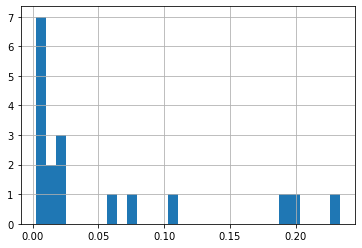

In [67]:
pd.Series(clf.feature_importances_).hist(bins=30)

In [68]:
x = pipe.named_steps["fs"]

In [69]:
sum(pipe.named_steps["fs"].get_support()) / X_new.shape[1]

1.0

In [70]:
#y_train = y_train.iloc[X_train.index].reset_index(drop=True)
#X_train.reset_index(inplace=True, drop=True)

In [71]:
#pipeline - pipeline_objective OR regular pipeline
#consider making pre-made steps with best practices (FS, scaling, etc...) then add option to concat to make one pipeline 

In [72]:
#pipeline = Pipeline([("sel", SelectPercentile(chi2))])
#pipe_params = {"sel__percentile" : optuna.distributions.IntUniformDistribution(1,100)}
pipeline = None
pipe_params = None

In [73]:
from sklearn.model_selection import GridSearchCV

In [80]:
gr = GridSearchCV(estimator=RandomForestClassifier(n_estimators=10), cv=5, param_grid={"max_depth" : [5, 10]})

In [81]:
gr.fit(X_new, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='wa

In [86]:
preds = gr.predict(pipe.transform(X_test))

In [88]:
boston

NameError: name 'boston' is not defined

In [ ]:
TargetEncoder()

In [87]:
sklearn.metrics.accuracy_score(preds, y_test)

TypeError: '<' not supported between instances of 'str' and 'int'

# Classifier

In [55]:
dataset = "newsgroup" #adult, boston

In [56]:
if dataset=="adult":
    X_train = pd.read_pickle("./data/adult_X_train.pkl")
    y_train = pd.read_pickle("./data/adult_y_train.pkl")
    X_test = pd.read_pickle("./data/adult_X_test.pkl")
    y_test = pd.read_pickle("./data/adult_y_test.pkl")
    cat_cols = X_train.select_dtypes(include="object").columns
elif dataset=="newsgroup":
    X_train = load_npz("./data/X_train.npz")
    y_train = pd.read_pickle("./data/y_train.pkl")
    X_test = load_npz("./data/X_test.npz")
    y_test = pd.read_pickle("./data/y_test.pkl")
    cat_cols=None
else:
    X_train = pd.read_pickle("./data/boston_X_train.pkl")
    y_train = pd.read_pickle("./data/boston_y_train.pkl")
    X_test = pd.read_pickle("./data/boston_X_test.pkl")
    y_test = pd.read_pickle("./data/boston_y_test.pkl")
    cat_cols = None

In [57]:
xgb_linear = XGBClassifierHypster(booster_list=['gblinear'], n_iter_per_round=2
                               ,param_dict={'verbosity':1})
                               #,'subsample' : 0.9
#gb_dart = XGBClassifierHypster(booster_list=['dart'])
#xgb_tree = XGBClassifierHypster(booster_list=['gbtree', 'dart'], user_param_dict={'max_depth' : 2})
xgb_tree = XGBClassifierHypster(booster_list=['gbtree', 'dart'],
                                n_iter_per_round=5
                                )
#lgb_estimator = LGBClassifierOptuna()
#sgd_estimator = SGDClassifierOptuna()
#rf_estimator  = RFClassifierOptuna()

In [58]:
estimators = [xgb_tree] #, xgb_tree]#, sgd|_estimator]

In [59]:
sampler = optuna.integration.CmaEsSampler(n_startup_trials=30,
                      independent_sampler=TPESampler(**TPESampler.hyperopt_parameters()),
                      warn_independent_sampling=False, seed=SEED)

In [60]:
sampler = TPESampler(**TPESampler.hyperopt_parameters(), seed=SEED)

In [75]:
clf = HyPSTERClassifier(estimators, pipeline, pipe_params, save_cv_preds=True, 
                        scoring="roc_auc", cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED), tol=1e-6,
                        sampler=sampler, refit=False, random_state=SEED, max_iter=20, n_jobs=-1)

In [76]:
X_new.shape

(32561, 18)

In [77]:
y_train.shape

(10309,)

In [78]:
X_train

<10309x30715 sparse matrix of type '<class 'numpy.float64'>'
	with 791750 stored elements in Compressed Sparse Row format>

In [79]:
%%time
clf.fit(X_train, y_train, cat_columns=cat_cols, n_trials_per_estimator=100)

XGBoost Classifier
Score: 0.83403


[W 2019-08-24 16:47:59,051] Setting status of trial#6 as TrialState.FAIL because of the following error: ValueError('No trials are completed yet.')
Traceback (most recent call last):
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\study.py", line 469, in _run_trial
    result = func(trial)
  File "c:\python_workspace\HyPSTER\hypster.py", line 251, in __call__
    condition = best_score > trial.study.best_value
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\study.py", line 183, in best_value
    best_value = self.best_trial.value
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\study.py", line 198, in best_trial
    return self.storage.get_best_trial(self.study_id)
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\storages\base.py", line 181, in get_best_trial
    raise ValueError('No trials are completed yet.')
ValueError: No trials are completed yet.


Score: 0.82254


[W 2019-08-24 16:48:13,264] Setting status of trial#3 as TrialState.FAIL because of the following error: ValueError('No trials are completed yet.')
Traceback (most recent call last):
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\study.py", line 469, in _run_trial
    result = func(trial)
  File "c:\python_workspace\HyPSTER\hypster.py", line 251, in __call__
    condition = best_score > trial.study.best_value
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\study.py", line 183, in best_value
    best_value = self.best_trial.value
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\study.py", line 198, in best_trial
    return self.storage.get_best_trial(self.study_id)
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\storages\base.py", line 181, in get_best_trial
    raise ValueError('No trials are completed yet.')
ValueError: No trials are completed yet.


Score: 0.85437


[W 2019-08-24 16:48:37,190] Setting status of trial#4 as TrialState.FAIL because of the following error: ValueError('No trials are completed yet.')
Traceback (most recent call last):
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\study.py", line 469, in _run_trial
    result = func(trial)
  File "c:\python_workspace\HyPSTER\hypster.py", line 251, in __call__
    condition = best_score > trial.study.best_value
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\study.py", line 183, in best_value
    best_value = self.best_trial.value
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\study.py", line 198, in best_trial
    return self.storage.get_best_trial(self.study_id)
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\storages\base.py", line 181, in get_best_trial
    raise ValueError('No trials are completed yet.')
ValueError: No trials are completed yet.


KeyboardInterrupt: 

In [81]:
clf.study

AttributeError: 'HyPSTERClassifier' object has no attribute 'study'

Score: 0.87836


[W 2019-08-24 16:49:58,353] Setting status of trial#8 as TrialState.FAIL because of the following error: ValueError('No trials are completed yet.')
Traceback (most recent call last):
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\study.py", line 469, in _run_trial
    result = func(trial)
  File "c:\python_workspace\HyPSTER\hypster.py", line 251, in __call__
    condition = best_score > trial.study.best_value
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\study.py", line 183, in best_value
    best_value = self.best_trial.value
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\study.py", line 198, in best_trial
    return self.storage.get_best_trial(self.study_id)
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\storages\base.py", line 181, in get_best_trial
    raise ValueError('No trials are completed yet.')
ValueError: No trials are completed yet.


Score: 0.86393


[W 2019-08-24 16:50:15,982] Setting status of trial#13 as TrialState.FAIL because of the following error: ValueError('No trials are completed yet.')
Traceback (most recent call last):
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\study.py", line 469, in _run_trial
    result = func(trial)
  File "c:\python_workspace\HyPSTER\hypster.py", line 251, in __call__
    condition = best_score > trial.study.best_value
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\study.py", line 183, in best_value
    best_value = self.best_trial.value
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\study.py", line 198, in best_trial
    return self.storage.get_best_trial(self.study_id)
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\storages\base.py", line 181, in get_best_trial
    raise ValueError('No trials are completed yet.')
ValueError: No trials are completed yet.


Score: 0.88799


[W 2019-08-24 16:50:20,014] Setting status of trial#12 as TrialState.FAIL because of the following error: ValueError('No trials are completed yet.')
Traceback (most recent call last):
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\study.py", line 469, in _run_trial
    result = func(trial)
  File "c:\python_workspace\HyPSTER\hypster.py", line 251, in __call__
    condition = best_score > trial.study.best_value
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\study.py", line 183, in best_value
    best_value = self.best_trial.value
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\study.py", line 198, in best_trial
    return self.storage.get_best_trial(self.study_id)
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\storages\base.py", line 181, in get_best_trial
    raise ValueError('No trials are completed yet.')
ValueError: No trials are completed yet.


Score: 0.88238


[W 2019-08-24 16:50:25,061] Setting status of trial#11 as TrialState.FAIL because of the following error: ValueError('No trials are completed yet.')
Traceback (most recent call last):
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\study.py", line 469, in _run_trial
    result = func(trial)
  File "c:\python_workspace\HyPSTER\hypster.py", line 251, in __call__
    condition = best_score > trial.study.best_value
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\study.py", line 183, in best_value
    best_value = self.best_trial.value
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\study.py", line 198, in best_trial
    return self.storage.get_best_trial(self.study_id)
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\storages\base.py", line 181, in get_best_trial
    raise ValueError('No trials are completed yet.')
ValueError: No trials are completed yet.


Score: 0.92298


[W 2019-08-24 16:51:22,274] Setting status of trial#17 as TrialState.FAIL because of the following error: ValueError('No trials are completed yet.')
Traceback (most recent call last):
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\study.py", line 469, in _run_trial
    result = func(trial)
  File "c:\python_workspace\HyPSTER\hypster.py", line 251, in __call__
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\study.py", line 183, in best_value
    best_value = self.best_trial.value
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\study.py", line 198, in best_trial
    return self.storage.get_best_trial(self.study_id)
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\storages\base.py", line 181, in get_best_trial
    raise ValueError('No trials are completed yet.')
ValueError: No trials are completed yet.


Score: 0.90179


[W 2019-08-24 16:51:30,685] Setting status of trial#23 as TrialState.FAIL because of the following error: ValueError('No trials are completed yet.')
Traceback (most recent call last):
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\study.py", line 469, in _run_trial
    result = func(trial)
  File "c:\python_workspace\HyPSTER\hypster.py", line 251, in __call__
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\study.py", line 183, in best_value
    best_value = self.best_trial.value
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\study.py", line 198, in best_trial
    return self.storage.get_best_trial(self.study_id)
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\storages\base.py", line 181, in get_best_trial
    raise ValueError('No trials are completed yet.')
ValueError: No trials are completed yet.


Score: 0.92738


[W 2019-08-24 16:51:33,986] Setting status of trial#21 as TrialState.FAIL because of the following error: ValueError('No trials are completed yet.')
Traceback (most recent call last):
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\study.py", line 469, in _run_trial
    result = func(trial)
  File "c:\python_workspace\HyPSTER\hypster.py", line 251, in __call__
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\study.py", line 183, in best_value
    best_value = self.best_trial.value
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\study.py", line 198, in best_trial
    return self.storage.get_best_trial(self.study_id)
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\storages\base.py", line 181, in get_best_trial
    raise ValueError('No trials are completed yet.')
ValueError: No trials are completed yet.


Score: 0.922


[W 2019-08-24 16:51:45,875] Setting status of trial#19 as TrialState.FAIL because of the following error: ValueError('No trials are completed yet.')
Traceback (most recent call last):
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\study.py", line 469, in _run_trial
    result = func(trial)
  File "c:\python_workspace\HyPSTER\hypster.py", line 251, in __call__
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\study.py", line 183, in best_value
    best_value = self.best_trial.value
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\study.py", line 198, in best_trial
    return self.storage.get_best_trial(self.study_id)
  File "C:\Users\user\Anaconda3\lib\site-packages\optuna\storages\base.py", line 181, in get_best_trial
    raise ValueError('No trials are completed yet.')
ValueError: No trials are completed yet.


In [1239]:
clf.best_score_

0.8815550458780482

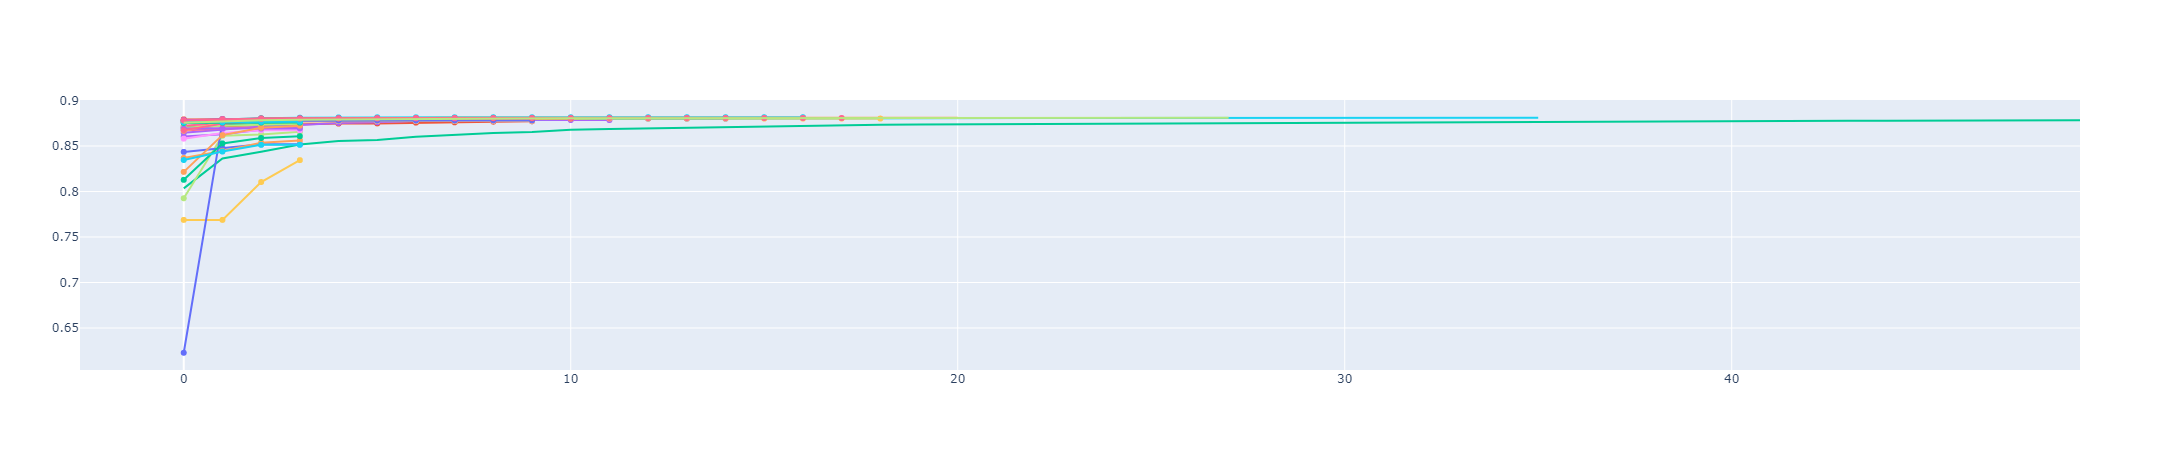

In [1240]:
plot_intermediate_values(clf.study)

In [1236]:
clf.best_params_

{'eta': 0.16610158790808505,
 'booster': 'gbtree',
 'lambda': 0.0408924003728524,
 'alpha': 9.714125441010932e-10,
 'scale_pos_weight': 1.0,
 'max_depth': 11,
 'min_child_weight': 12,
 'gamma': 1.2227146439953899e-09,
 'grow_policy': 'depthwise',
 'subsample': 0.5368202696502619,
 'colsample_bytree': 0.5877070497589822,
 'colsample_bynode': 0.948732933830148,
 'forest_boosting': True,
 'num_parallel_tree': 7}

In [1237]:
clf.refit(X_new, y_train)

In [1241]:
test_preds = clf.predict(pipe.transform(X_test))

In [1242]:
sklearn.metrics.accuracy_score(y_test, test_preds)

0.8347153123272526

In [1244]:
test_probs = clf.predict_proba(pipe.transform(X_test))
test_probs = test_probs[:,1]

In [1245]:
sklearn.metrics.roc_auc_score(y_test, test_probs)

0.8806864023656241

In [1246]:
best_cv_preds = clf.study.best_trial.user_attrs['cv_preds']

In [1247]:
best_cv_preds.shape

(32561, 2)

In [1248]:
best_cv_preds

array([[0.92147124, 0.07852877],
       [0.37885696, 0.62114304],
       [0.96839225, 0.03160778],
       ...,
       [0.96994168, 0.03005835],
       [0.99314654, 0.00685347],
       [0.41260648, 0.58739352]])

# Regressor

In [ ]:
#TODO: automatic seed
xgb_linear = XGBRegressorHypster(booster_list=['gblinear']
                               ,param_dict={'nthread' : 1
                                            #TODO check what happens when you run over parameters in optuna
                               #,'subsample' : 0.9
                               }
                               )
xgb_tree = XGBRegressorHypster(booster_list=['gbtree', 'dart'], 
                               param_dict={'max_depth' : optuna.distributions.IntUniformDistribution(2, 20)
                                               ,'nthread' : 1
                                               #,'subsample' : 0.9 
                                               })
#lgb_estimator = LGBClassifierOptuna()
#sgd_estimator = SGDClassifierOptuna()
#rf_estimator  = RFClassifierOptuna()

In [ ]:
estimators = [xgb_linear, xgb_tree]#, sgd|_estimator]

In [ ]:
reg = HyPSTERRegressor(estimators, pipeline, pipe_params,
                        scoring="neg_mean_squared_error", cv=KFold(n_splits=3, random_state=SEED), sampler=sampler, 
                        refit=False, random_state=SEED, n_jobs=-1)

In [ ]:
%%time
reg.fit(X_train, y_train, cat_columns=cat_columns, n_trials_per_estimator=[10, 60])

In [ ]:
reg.best_score_

In [ ]:
reg.best_params_

In [ ]:
reg.refit(X_train, y_train)

In [ ]:
test_preds = reg.predict(X_test)

In [ ]:
sklearn.metrics.mean_absolute_error(y_test, test_preds)

In [ ]:
np.sqrt(sklearn.metrics.mean_squared_error(y_test, test_preds))

# Misc

# Decision Tree